

---

#### Note: Throughout the thesis code/notebooks, to reproduce different results and methods, code cells are edited and desired paramteres entered and re-ran. Code is commented out and in at times when we want to use different variables etc, this saves having lots of repeated code clogging up the notebooks. Output from cells is not always maintained.


---





---

# Installations & Imports


---



In [ ]:
!pip install tensorflow-io
!pip install pydub
!pip install wget
!pip install imbalanced-learn

     |████████████████████████████████| 23.4 MB 491 kB/s 
     |████████████████████████████████| 2.1 MB 62.8 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.24.0
    Uninstalling tensorflow-io-gcs-filesystem-0.24.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d74072e149a2cf68f8505a81686af1276873463e6e7759e43503648ffb7c8b65
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import librosa
import json
import os 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.combine import SMOTEENN

from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced 
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings('ignore')



---

# Functions


---



---



In [ ]:
def format_base_features(df):
  """ 
    Flattens and formats baseline features as input into ML models
    
    Input: Dataframe
    Returns : Formatted Dataframe
  """
  
  v = np.column_stack([df.id.values, df.mfcc.values.tolist()])
  c = ['id'] + ['mfcc{}'.format(i) for i in range(v.shape[1] - 1)] 
  df2 = pd.DataFrame(v, df.index, c)
  df2['zcr_max'] = df['zcr_max']
  df2['zcr_mean'] = df['zcr_mean'] 
  df2['label'] = df['label']
  
  return df2


def format_pretrained_features(df):
  """ 
    Flattens and formats pretrained feature vectors as input into ML models
    
    Input: Dataframe
    Returns : Formatted Dataframe
  """

  v2 = np.column_stack([df.id.values, df.trill_embedding.values.tolist()])
  c2 = ['id'] + ['trill{}'.format(i) for i in range(v2.shape[1] - 1)] 
  df2 = pd.DataFrame(v2, df.index, c2)
  df2['label'] = df['label']

  return df2


def split_scale_data(X, y, scaled=True):
  """ 
    Flattens and formats baseline features as input into ML models
    
    Input: X features and y labels, optional scaling param
    Returns : Train/test splits of data
  """

  scaler = StandardScaler()

  features_scaled = X 
  features_scaled = scaler.fit_transform(features_scaled)
  features_scaled_df = pd.DataFrame(features_scaled)

  ## Unscaled test/train set 
  X_train, X_test, y_train, y_test = train_test_split(
      X, 
      y, 
      test_size=0.2, 
      random_state=69
  )

  ## Standard Scaled test/train set
  X_train_scaled, X_test_scaled, _, _ = train_test_split(
      features_scaled, 
      y, 
      test_size=0.2, 
      random_state=69
  )

  if scaled:
    return X_train_scaled, X_test_scaled, y_train, y_test
  else:
    return X_train, X_test, y_train, y_test

  
def evaluate_kfold(X, y, model, model_name, X_aug=None, y_aug=None, sampling=False, cf_matrix=False, augment=False, strategy=0.5, roc_curve=False):
  """ 
    Master function for training all models with cross validation.
    Auxiliary techinqeus 
    
    Input: Model, data and optional parameters
    Returns : Cross Validated Metric Scores
  """
  np.random.seed(196058)

  cv_scores = {
      'roc_auc':[],
      'f1_weighted':[],
      'f1_macro':[],
      'accuracy':[],
      'precision':[],
      'recall':[]
  }

  # For plotting ROC curves
  if roc_curve:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

  # Define stratified approach
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

  # enumerate the splits and summarize the distributions
  for i, (train_ix, test_ix) in enumerate(kfold.split(X, y)):
    # select rows
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    # summarize train and test composition
    # train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    # test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    # print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

    # Apply auxiliary techniques such as sampling, augmentation etc
    if sampling=='over':
      # do sampling on train data
      X_train_bal, y_train_bal = over_sampling(model, X_train, y_train, strategy)
      train_0, train_1 = len(y_train_bal[y_train_bal==0]), len(y_train_bal[y_train_bal==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
      model.fit(X_train_bal, y_train_bal)
    elif sampling=='under':
      X_train_bal, y_train_bal = under_sampling(model, X_train, y_train, strategy)
      train_0, train_1 = len(y_train_bal[y_train_bal==0]), len(y_train_bal[y_train_bal==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
      model.fit(X_train_bal, y_train_bal)
    elif sampling=='combo':
      X_train_bal, y_train_bal = combo_sampling(model, X_train, y_train, strategy)
      train_0, train_1 = len(y_train_bal[y_train_bal==0]), len(y_train_bal[y_train_bal==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
      model.fit(X_train_bal, y_train_bal)
    elif augment==True:
      X_train = np.concatenate((X_train, X_aug), axis=0)
      y_train = np.concatenate((y_train, y_aug), axis=0)
      # print(X_train.shape, y_train.shape)
      
      model.fit(X_train, y_train)
    else:
      model.fit(X_train, y_train)
    
    ### Predict ###
    y_pred = model.predict(X_test)

    ### Compute various metrics 
    cv_scores['roc_auc'].append( round(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100, 1 ))
    cv_scores['accuracy'].append( round(metrics.accuracy_score(y_test, y_pred) * 100, 1))
    cv_scores['f1_weighted'].append( round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 1))
    cv_scores['f1_macro'].append( round(metrics.f1_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['precision'].append( round(metrics.precision_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['recall'].append( round(metrics.recall_score(y_test, y_pred, average='macro') * 100, 1))

    # Optional ROC curve plotting
    if roc_curve is True:
      viz = RocCurveDisplay.from_estimator(
          model,
          X_test,
          y_test,
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

    # Optional confusion matrix plotting
    if cf_matrix:
      cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
      disp.plot()
      plt.show()

      
  res = [model_name]
  for x in cv_scores.keys():
    res.append(np.mean(cv_scores[x]))

  if roc_curve is True:
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance/DummyClf", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="purple",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC Curve - Closing 5 mins audio",
    )
    ax.legend(loc="lower right", prop={'size': 8})
    plt.show()

  return res

def over_sampling(model, features, labels, strategy):
  """ 
    Input: Model, data and optional parameters
    Returns : Over sampled training set
  """

  over = SMOTE(sampling_strategy=strategy, random_state=42)
  X_train_bal, y_train_bal = over.fit_resample(features, labels)

  return X_train_bal, y_train_bal

def under_sampling(model, features, labels, strategy):
  """ 
    Input: Model, data and optional parameters
    Returns : Under sampled training set
  """

  under = RandomUnderSampler(sampling_strategy=strategy, random_state=42)
  X_train_bal, y_train_bal = under.fit_resample(features, labels)

  return X_train_bal, y_train_bal

def combo_sampling(model, features, labels, strategy):
  """ 
    Input: Model, data and optional parameters
    Returns : Under and Over sampled training set
  """

  combo = SMOTEENN(random_state=42, sampling_strategy=strategy)
  X_train_bal, y_train_bal = combo.fit_resample(features, labels)

  return X_train_bal, y_train_bal





---

# Read In Clean Datasets

---



In [ ]:
# Baseline features and pretrained TRILLSson features
base_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/baseline_final_dataset.json", lines=True)
trill_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/pretrained_final_dataset.json", lines=True)

In [ ]:
# Time sampling variants 
# - close 5 mins
# - lead 5 mins
end_base_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/baseline_end_final_dataset.json", lines=True)
lead_base_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/baseline_lead_final_dataset.json", lines=True)



---

# Format features for traditioal ML models


---



In [ ]:
base_df = format_base_features(base_df)
trill_df = format_pretrained_features(trill_df)

print(base_df.shape, trill_df.shape)

(3618, 24) (3618, 3074)


In [ ]:
end_base_df = format_base_features(end_base_df)
lead_base_df = format_base_features(lead_base_df)

print(end_base_df.shape, lead_base_df.shape)

## Augmented Pretrained Features

In [ ]:
aug_trill_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/aug_pretrained_final_dataset.json", lines=True)
aug_trill_df = format_pretrained_features(aug_trill_df)

X_aug = aug_trill_df.iloc[:,1:-1]
y_aug = aug_trill_df['label']



---

# Training

---



## 1.) Storing different datasets in a dictionary
## 2.) Defining range of models

In [ ]:
# Create dict of X, y for easy reuse of splits for both feature sets
splits = {}

X = base_df.iloc[:,1:-1]
y = base_df['label']
splits['base'] = [X, y]

X = trill_df.iloc[:,1:-1]
y = trill_df['label']
splits['trill'] = [X, y]

# X = end_base_df.iloc[:,1:-1]
# y = end_base_df['label']
# splits['end'] = [X, y]

# X = lead_base_df.iloc[:,1:-1]
# y = lead_base_df['label']
# splits['lead'] = [X, y]

# X = new_trill_df.iloc[:,1:-1]
# y = new_trill_df['label']
# splits['aug_trill'] = [X, y]


# Range of baseline models to train and evaluate
# Default params
classification_models = [
    KNeighborsClassifier(),
    SVC(kernel='linear', probability=True),
    LogisticRegression(),   #C=1.0, class_weight={0: 0.9850251256281407, 1: 0.014974874371859292}, penalty='l2', solver='newton-cg'), #(C=100, penalty='l2', max_iter=1000)] #, #C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'
    DecisionTreeClassifier(max_depth=5),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    DummyClassifier()]



---


# Evaluate Baseline Features



---



---



## -> Experimenting with different time sampling

In [ ]:
X, y = splits['base'][0], splits['base'][1]
# X, y = splits['lead'][0], splits['lead'][1]
# X, y = splits['end'][0], splits['end'][1]

scaler = StandardScaler()

# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(features_scaled, y, model, model_name, sampling=False, strategy=0.7, cf_matrix=False, roc_curve=False)

    # Append model scores for comparison
    scores.append(kfold_score)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
df.head(6)

,Classifier,roc_auc,f1_weighted,f1_macro,accuracy,precision,recall
4,AdaBoostClassifier,57.08,82.04,47.62,87.22,50.34,50.16
3,DecisionTreeClassifier,54.70,82.10,49.00,86.60,53.14,50.70
6,DummyClassifier,50.00,82.08,46.76,87.76,43.90,50.00
5,GradientBoostingClassifier,57.00,81.96,47.04,87.36,47.30,49.98
0,KNeighborsClassifier,54.92,81.96,48.40,86.64,52.06,50.30
2,LogisticRegression,61.68,82.08,46.76,87.76,43.90,50.00


In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro &  accuracy &  precision &  recall \\\\\n\\midrule\n        AdaBoostClassifier &    57.08 &        82.04 &     47.62 &     87.22 &      78.66 &   87.22 \\\\\n    DecisionTreeClassifier &    54.70 &        82.10 &     49.00 &     86.60 &      79.44 &   86.60 \\\\\n           DummyClassifier &    50.00 &        82.08 &     46.76 &     87.76 &      77.04 &   87.76 \\\\\nGradientBoostingClassifier &    57.00 &        81.96 &     47.04 &     87.36 &      77.88 &   87.36 \\\\\n      KNeighborsClassifier &    54.92 &        81.96 &     48.40 &     86.64 &      79.10 &   86.64 \\\\\n        LogisticRegression &    61.68 &        82.08 &     46.76 &     87.76 &      77.04 &   87.76 \\\\\n                       SVC &    52.32 &        82.08 &     46.76 &     87.76 &      77.04 &   87.76 \\\\\n\\bottomrule\n\\end{tabular}\n'



---


# Evaluate Pretrained Embeddings


---



---



## Augmented samples are generated for each podcast episode
## *Augmentation is only applied to training set in the evaluate_kfold function via the augment=True

In [ ]:
# reduced_data = PCA(n_components=2).fit_transform(data)
# kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
# kmeans.fit(reduced_data)

In [ ]:
X, y = splits['trill'][0], splits['trill'][1]

scaler = StandardScaler()

# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(features_scaled, 
                                 y, 
                                 model, 
                                 model_name, 
                                 X_aug=X_aug, 
                                 y_aug=y_aug, 
                                 sampling=False, 
                                 augment=False, 
                                 strategy=0.5)

    # Append model scores for comparison
    scores.append(kfold_score)

df=pd.DataFrame(scores,columns=['Classifier', 'roc_auc','f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df = df.sort_values(by=['Classifier'])
df.head(6)

KNeighborsClassifier
SVC
LogisticRegression
DecisionTreeClassifier
AdaBoostClassifier
GradientBoostingClassifier
DummyClassifier


,Classifier,roc_auc,f1_weighted,f1_macro,accuracy,precision,recall
4,AdaBoostClassifier,63.16,82.40,52.74,85.32,80.50,85.32
3,DecisionTreeClassifier,57.20,81.40,48.92,85.08,78.54,85.08
6,DummyClassifier,50.00,82.08,46.76,87.76,77.04,87.76
5,GradientBoostingClassifier,65.42,82.16,48.08,87.32,79.88,87.32
0,KNeighborsClassifier,56.78,82.18,50.50,85.98,79.98,85.98
2,LogisticRegression,57.32,80.10,54.54,79.70,80.50,79.70


In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro &  accuracy &  precision &  recall \\\\\n\\midrule\n        AdaBoostClassifier &    63.14 &        82.54 &     51.90 &     86.08 &      80.84 &   86.08 \\\\\n    DecisionTreeClassifier &    59.78 &        82.42 &     50.32 &     86.66 &      80.54 &   86.66 \\\\\nGradientBoostingClassifier &    66.12 &        82.00 &     47.42 &     87.24 &      78.72 &   87.24 \\\\\n      KNeighborsClassifier &    56.76 &        82.16 &     50.48 &     85.96 &      79.96 &   85.96 \\\\\n        LogisticRegression &    66.20 &        82.88 &     55.42 &     85.06 &      81.44 &   85.06 \\\\\n                       SVC &    62.16 &        79.78 &     56.42 &     78.36 &      81.50 &   78.36 \\\\\n\\bottomrule\n\\end{tabular}\n'



---

# Imbalanced Dataset Techniques


---



## 1. Just oversampling via SMOTE

In [ ]:
X, y = splits['base'][0], splits['base'][1]

scaler = StandardScaler()

# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set


# for x in np.linspace(0.3,1,11):
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(features_scaled, y, model, model_name, sampling='over', strategy=0.7)

    # Append model scores for comparison
    scores.append(kfold_score)

# df=pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'pr_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
# df.head(6)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
print(df.head(6))

>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2540, 1=1778, Test: 0=636, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
KNeighborsClassifier
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2540, 1=1778, Test: 0=636, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
SVC
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2540, 1=1778, Test: 0=636, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
LogisticRegression
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2540, 1=1778, Test: 0=636, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
>Train: 0=2541, 1=1778, Test: 0=635, 1=88
DecisionTreeClassifier
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0=2541, 1=1778, Test: 0=635, 1=89
>Train: 0

In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro \\\\\n\\midrule\n        AdaBoostClassifier &    58.20 &        73.66 &     51.58 \\\\\n    DecisionTreeClassifier &    55.02 &        72.30 &     49.54 \\\\\nGradientBoostingClassifier &    57.36 &        77.98 &     53.08 \\\\\n      KNeighborsClassifier &    56.82 &        66.04 &     47.62 \\\\\n        LogisticRegression &    61.72 &        76.72 &     54.32 \\\\\n                       SVC &    61.84 &        77.90 &     54.36 \\\\\n\\bottomrule\n\\end{tabular}\n'


## 2. Undersampling


In [ ]:
X, y = splits['base'][0], splits['base'][1]

scaler = StandardScaler()

# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

# for x in np.linspace(0.2,1,11):
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(features_scaled, y, model, model_name, sampling='under', strategy=0.7)

    # Append model scores for comparison
    scores.append(kfold_score)

# df=pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'pr_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
# df.head(6)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
print(df.head(6))

>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=505, 1=354, Test: 0=636, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
KNeighborsClassifier
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=505, 1=354, Test: 0=636, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
SVC
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=505, 1=354, Test: 0=636, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
LogisticRegression
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=505, 1=354, Test: 0=636, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
>Train: 0=505, 1=354, Test: 0=635, 1=88
DecisionTreeClassifier
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=504, 1=353, Test: 0=635, 1=89
>Train: 0=505, 1=354, Test: 0=636, 1=88
>Train: 0=505

In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro \\\\\n\\midrule\n        AdaBoostClassifier &    56.34 &        71.20 &     50.20 \\\\\n    DecisionTreeClassifier &    52.86 &        70.90 &     48.12 \\\\\nGradientBoostingClassifier &    56.60 &        73.62 &     51.38 \\\\\n      KNeighborsClassifier &    56.54 &        70.14 &     49.62 \\\\\n        LogisticRegression &    60.86 &        76.78 &     54.44 \\\\\n                       SVC &    60.66 &        79.66 &     53.88 \\\\\n\\bottomrule\n\\end{tabular}\n'

## 3. Under + Over Sampling

In [ ]:
X, y = splits['base'][0], splits['base'][1]

scaler = StandardScaler()

# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

# for x in np.linspace(0.2,1,11):
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(features_scaled, y, model, model_name, sampling='combo', strategy=x)

    # Append model scores for comparison
    scores.append(kfold_score)

# df=pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'pr_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
# df.head(6)

df = pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro'])
df = df.sort_values(by=['Classifier'])
# df = df.applymap(lambda x: (str(x) + '%'))
print(df.head(6))

>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1770, 1=1416, Test: 0=636, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
KNeighborsClassifier
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1770, 1=1416, Test: 0=636, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
SVC
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1770, 1=1416, Test: 0=636, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
LogisticRegression
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1770, 1=1416, Test: 0=636, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
>Train: 0=1770, 1=1416, Test: 0=635, 1=88
DecisionTreeClassifier
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0=1765, 1=1412, Test: 0=635, 1=89
>Train: 0

In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{lrrr}\n\\toprule\n                Classifier &  roc\\_auc &  f1\\_weighted &  f1\\_macro \\\\\n\\midrule\n        AdaBoostClassifier &    57.88 &        71.34 &     50.62 \\\\\n    DecisionTreeClassifier &    54.90 &        65.12 &     46.42 \\\\\nGradientBoostingClassifier &    56.64 &        75.12 &     51.56 \\\\\n      KNeighborsClassifier &    57.58 &        62.28 &     45.58 \\\\\n        LogisticRegression &    61.80 &        73.30 &     52.74 \\\\\n                       SVC &    61.90 &        72.34 &     52.50 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
X, y = splits['base'][0], splits['base'][1]
model = AdaBoostClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

# combo = SMOTEENN(sampling_strategy=0.2)
# X_bal, y_bal = combo.fit_resample(X, y)


over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.563
Mean ROC AUC: 0.560




---

# Traditional Hyperparameter Tuning

---


## Based on top 3 performing classifiers

In [ ]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

lr_params = {
    'penalty':['l1', 'l2'], 
    'C': np.logspace(0, 4, 10),
    'solver': ['newton-cg', 'lbfgs', 'linear'],
    'class_weight': [{0:x, 1:1.0-x} for x in weights]
}

gbc_params = {
    "n_estimators":[5,50,250,500],
    "max_depth":[3,5,7,],
    "learning_rate":[0.01,0.1,1,10,100],
    # "criterion":['friedman_mse', 'squared_error', 'mse'],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    # "min_samples_leaf": np.linspace(0.1, 0.5, 12)
}

ada_params = {
    "n_estimators":[5,50,250,500],
    "learning_rate":[0.01,0.1,1,10,100],
    "algorithm":['SAMME', 'SAMME.R']
}

svc_params = {
    'kernel':['linear', 'rbf', 'sigmoid'], 
    'C': np.logspace(0, 4, 10),
    'class_weight': [{0:x, 1:1.0-x} for x in weights],
    'gamma':['scale', 'auto']
}



In [ ]:
X, y = splits['base'][0], splits['base'][1]

X_train, X_test, y_train, y_test = split_scale_data(X, y)

## 1. LR

In [ ]:
lr = LogisticRegression()

# X, y = splits['trill'][0], splits['trill'][1]

# X_train, X_test, y_train, y_test = split_scale_data(X, y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(lr,
                    param_grid=lr_params,
                    scoring='roc_auc',
                    cv=cv,
                    verbose=10)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

## 2. GBC

In [ ]:
gbc = GradientBoostingClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(gbc,
                    param_grid=gbc_params,
                    scoring='roc_auc',
                    cv=cv,
                    verbose=10)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

## 3. SVC

In [ ]:
svc = SVC()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid = GridSearchCV(svc,
                    param_grid=svc_params,
                    scoring='roc_auc',
                    cv=cv,
                    verbose=10)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 12000 candidates, totalling 60000 fits
[CV 1/5; 1/12000] START C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear
[CV 1/5; 1/12000] END C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear;, score=nan total time=   0.3s
[CV 2/5; 1/12000] START C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear
[CV 2/5; 1/12000] END C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear;, score=nan total time=   0.2s
[CV 3/5; 1/12000] START C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear
[CV 3/5; 1/12000] END C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear;, score=nan total time=   0.2s
[CV 4/5; 1/12000] START C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear
[CV 4/5; 1/12000] END C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear;, score=nan total time=   0.2s
[CV 5/5; 1/12000] START C=1.0, class_weight={0: 0.0, 1: 1.0}, gamma=scale, kernel=linear
[CV 5/5; 1/12000

KeyboardInterrupt: ignored

In [ ]:
ada_params = {
    "n_estimators":[5,50,250,500],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['Non-Popular', 'Popular']))
print('Test set AUC', metrics.roc_auc_score(y_test, y_pred))

model2 = LogisticRegression(C=0.01, penalty='l2', max_iter=1000)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=['Non-Popular', 'Popular']))
print('Test set AUC', metrics.roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

 Non-Popular       0.87      1.00      0.93       631
     Popular       0.00      0.00      0.00        93

    accuracy                           0.87       724
   macro avg       0.44      0.50      0.47       724
weighted avg       0.76      0.87      0.81       724

Test set AUC 0.5
              precision    recall  f1-score   support

 Non-Popular       0.87      1.00      0.93       631
     Popular       0.00      0.00      0.00        93

    accuracy                           0.87       724
   macro avg       0.44      0.50      0.47       724
weighted avg       0.76      0.87      0.81       724

Test set AUC 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

---

# Ensemble of Best Performing Models

---



## Voting

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

X, y = splits['base'][0], splits['base'][1]

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

estimators = [
     ('svc', SVC()),
     ('lr', GradientBoostingClassifier()),
     ('lr2', LogisticRegression()),
     ('ada', AdaBoostClassifier()),
     ('dt', DecisionTreeClassifier()),
     ('k', KNeighborsClassifier())
]

model = VotingClassifier(estimators=estimators, voting='soft')
model_hard = VotingClassifier(estimators=estimators, voting='hard')

models = [model, model_hard]
# For each model get CV scores and evaluate on test set
scores = []

for model in models:
  model_name = type(model).__name__

  # Evaluate with kfold validation (custom func)
  kfold_score = evaluate_kfold(features_scaled, y, model, model_name, sampling=False)

  # Append model scores for comparison
  scores.append(kfold_score)

df=pd.DataFrame(scores, columns=['Classifier', 'roc_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df.head(6)

## Stacking

In [ ]:

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('knn', KNeighborsClassifier()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('svm', GradientBoostingClassifier()))
	models.append(('bayes', AdaBoostClassifier()))
	return models

def get_stacking():
  # define the base models
  level0 = list()
  level0.append(('lr', LogisticRegression()))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier()))
  level0.append(('svm', SVC()))
  level0.append(('bayes', AdaBoostClassifier()))
  # define meta learner model
  level1 = LogisticRegression()
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model


stack = get_stacking()

classification_models.append(stack)

X, y = splits['base'][0], splits['base'][1]

scaler = StandardScaler()

# keep our unscaled features just in case we need to process them alternatively
features_scaled = X 
features_scaled = scaler.fit_transform(features_scaled)

# For each model get CV scores and evaluate on test set
scores = []
for model in classification_models:
    model_name = type(model).__name__
    
    # Evaluate with kfold validation (custom func)
    kfold_score = evaluate_kfold(features_scaled, y, model, model_name, sampling=False)

    # Append model scores for comparison
    scores.append(kfold_score)

df=pd.DataFrame(scores,columns=['Classifier', 'roc_auc', 'pr_auc', 'f1_weighted', 'f1_macro', 'accuracy', 'precision', 'recall'])
df.head(6)

KNeighborsClassifier
LogisticRegression
AdaBoostClassifier
GradientBoostingClassifier
StackingClassifier


,Classifier,roc_auc,pr_auc,f1_weighted,f1_macro,accuracy,precision,recall
0,KNeighborsClassifier,0.549141,0.140931,0.819561,0.483861,0.866225,0.791054,0.866225
1,LogisticRegression,0.616761,0.179018,0.820724,0.467471,0.877833,0.770592,0.877833
2,AdaBoostClassifier,0.570911,0.161140,0.820272,0.476166,0.872029,0.786577,0.872029
3,GradientBoostingClassifier,0.568039,0.146465,0.819021,0.468354,0.873411,0.775161,0.873411
4,StackingClassifier,0.610372,0.176544,0.820724,0.467471,0.877833,0.770592,0.877833




---

# General Plotting Code
## Results gotten from various notebooks

---



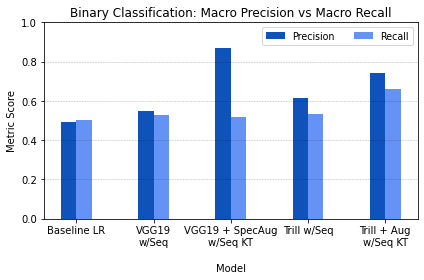

In [ ]:
# #aggregating pr from diff models
# data = np.array([[0.77, 0.877], #lr
#                  [0.871, 0.883],  # vgg and aug tuned 100
#                  [0.822, 0.844],  #trill
#                  [0.860, 0.896]])  # trill and aug tuned 100

data = np.array([[0.49, 0.50], #lr
                 [0.55, 0.53], # vgg baseline
                 [0.87, 0.52],  # vgg and aug tuned 100
                 [0.615, 0.535], # trill basline 20 epoch
                 [0.74, 0.66]])  # trill and aug tuned 100
                                

length=len(data)
# Set plot parameters
fig, ax = plt.subplots()
width = 0.20 # width of bar
x = np.arange(length)

x_labels = ['Baseline LR', 'VGG19\nw/Seq', 'VGG19 + SpecAug\nw/Seq KT', 'Trill w/Seq', 'Trill + Aug\nw/Seq KT\n']


ax.bar(x, data[:,0], width, color='#0F52BA', label='Precision') # yerr=data_std[:,0])
ax.bar(x + width, data[:,1], width, color='#6593F5', label='Recall') # yerr=data_std[:,1])

ax.set_ylabel('Metric Score')
ax.set_ylim(0, 1)
ax.set_xticks(x+width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Model')
ax.set_title('Binary Classification: Macro Precision vs Macro Recall')
ax.legend(prop={'size': 9.5}, ncol=2)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()

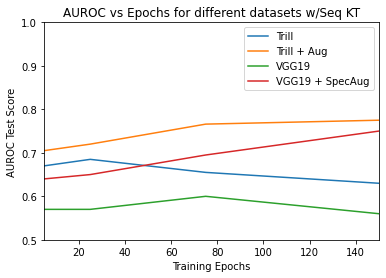

In [ ]:
# create data
x = [0.67, 0.685, 0.655, 0.63] # Trill 
y = [0.705, 0.72, 0.766, 0.775] # Trill + Aug
z = [0.57, 0.57, 0.60, 0.56]
u = [0.64, 0.65, 0.695, 0.75]

epoch = [5, 25, 75, 150]
  
# plot lines
plt.plot(epoch, x, label = "Trill")
plt.plot(epoch, y, label = "Trill + Aug")
plt.plot(epoch, z, label= "VGG19")
plt.plot(epoch, u, label= "VGG19 + SpecAug")

plt.ylim([0.5, 1])
plt.xlim([5, 150])
plt.ylabel('AUROC Test Score')
plt.xlabel('Training Epochs')
plt.title('AUROC vs Epochs for different datasets w/Seq KT')
# plt.xticks([0, 25, 75, 150])
plt.legend()
plt.show()